# Pathway Activity in Human PBMC Single Cells - Feature Importance Comparison

In this notebook we try to answer the following questions, as a follow-up to our benchmark analysis:
* Are there similar or common results between the different methods? do they point to cell types that are more easily identified?
* What are the discrepencies, in biological terms, between the methods?
* What key pathways, or category of pathways, were used in the analysis and are the indicative for certain cell types?
* Are there any biological insights that seem contradictory or unexplainable (i.e. irrelevant)?

To answer these questions we run a pathway consensus analysis. For each method (gsea, progeny, aucell, pathsingle) we performed feature importance test. This test is method dependent since they use different pathway sets. For example, GSEA uses gene sets downloaded from reactome, while PathSingle uses pathways from its pathway database (built from KEGG). We wrote Shapley-like (shap) library for explainable AI, to extract the most important features of the different models. We also used forward selection of features using sklearn.

The REACTOME gene sets were preprocessed for these tests. We wanted to reduce gene sets that are highly overlapped, in order to reduce noise and have a more condensed results. To this end we used the Jackard distance to identify closely related gene sets, and picked one representative from each pair.
We also added two more functions for feature importance calculation. The first function relies on P-values from the different methods, and is using Fisher's method to combine these values. Then it ranks the gene sets according to the combined P-values and according to the gene enrichments. Finally it merges these two rankings to get the final score.
The second function is using a 'leave-one-out' method to sort the pathways in accordance to their contribution to the K-Means clustering success. It returns the most important pathways in descending order.

Finally we assess the results by splitting the gene sets to biological categories, and emphasizing the similarity and differences accross methods.

Below is the code for identifying the most important features for each method. We compare all results and search for comonalities/discrepancies between methods.

We first download the 68K PBMC data and follow the standard `scanpy` workflow for normalisation of read counts and subsetting on the highly variable genes.

In [ ]:
%reload_ext autoreload
%autoreload 2
from __future__ import annotations
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler
from tqdm.notebook import tqdm
import session_info
import os
import warnings
import scanpy.external as sce
from metrics import *
import matplotlib.pyplot as plt
import magic
from activity import *
from pathlib import Path
from collections import defaultdict


#!pip install ipywidgets --upgrade
os.environ["LOKY_MAX_CPU_COUNT"] = '4'
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#sc.logging.print_versions()
#Filtering warnings from current version of matplotlib.
warnings.filterwarnings("ignore", message=".*Parameters 'cmap' will be ignored.*", category=UserWarning)
warnings.filterwarnings("ignore", message="Tight layout not applied.*", category=UserWarning)
#Fix /opt/conda-envs/atom/lib/python3.10/site-packages/decoupler/method_gsva.py:87
#rev_idx = np.abs(np.arange(n, 0, -1, dtype=nb.f4) - n / 2)
#Fix /opt/conda-envs/atom/lib/python3.10/site-packages/decoupler/method_aucell.py:37
#x_th = np.arange(1, fset.shape[0]+1, dtype=nb.i8)
#torch install:
#Using micromamba: micromamba install pytorch
#On windows using pip:
#pip install torch

The original dataset is from a single donor, from 10xgenomix. Fresh 68k PBMCs (Donor A).

- ~68,000 cells detected
- Sequenced on Illumina NextSeq 500 High Output with ~20,000 reads per cell
- 98bp read1 (transcript), 8bp I5 sample barcode, 14bp I7 GemCode barcode and 5bp read2 (UMI)
- Analysis run with --cells=24000

In [72]:
adata = sc.datasets.pbmc68k_reduced()
adata.obs['labels'] = adata.obs.bulk_labels.map({'CD14+ Monocyte':0, 'Dendritic':1, 'CD56+ NK':2, 'CD4+/CD25 T Reg':3, 'CD19+ B':4, 'CD8+ Cytotoxic T':5, 'CD4+/CD45RO+ Memory':6, 'CD8+/CD45RA+ Naive Cytotoxic':7, 'CD4+/CD45RA+/CD25- Naive T':8, 'CD34+':9})
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'labels'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

It seems that preprocessing steps such as normalization and scaling were already performed on the dataset.

### Run Magic

In [73]:
print(adata.raw.to_adata().X.todense()[:5,:5]) # X is a sparse matrix in CSR format.
sce.pp.magic(adata, name_list='all_genes')
adata.raw.to_adata().X[:5,:5]

[[0.    0.    0.    1.591 1.591]
 [1.55  0.    1.55  0.    0.   ]
 [0.    0.    1.374 0.    0.   ]
 [0.    0.    1.711 1.711 0.   ]
 [0.    0.    0.    1.275 0.   ]]


array([[-0.326, -0.191, -0.728, -0.301,  3.386],
       [ 1.171, -0.191,  0.795, -1.2  , -0.174],
       [-0.326, -0.191,  0.483, -1.2  , -0.174],
       [-0.326, -0.191,  1.134, -0.157, -0.174],
       [-0.326, -0.191, -0.728, -0.607, -0.174]], dtype=float32)

## Retrieving Gene Sets

In [ ]:
#Downloading reactome pathways, annotated in the C2 collection of MSigDB..
if not Path("./data/c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O './data/c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

reactome = gmt_to_decoupler("./data/c2.cp.reactome.v7.5.1.symbols.gmt")
print(len(reactome.geneset.unique()))
reactome.head()

1615


,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST


In [82]:
# Handle highly overlapping gene sets.
# Create a dictionary to store the genes in each gene set.
genes_in_sets = defaultdict(set)
for _, row in reactome.iterrows():
    genes_in_sets[row['geneset']].add(row['genesymbol'])

# Get unique gene sets from reactome.
unique_genesets = reactome['geneset'].unique()

# Calculate Jaccard similarity between gene sets.
jaccard_matrix = np.zeros((len(unique_genesets), len(unique_genesets)))
for i, geneset1 in enumerate(unique_genesets):
    for j, geneset2 in enumerate(unique_genesets):
        if i != j:
            intersection = len(genes_in_sets[geneset1].intersection(genes_in_sets[geneset2]))
            union = len(genes_in_sets[geneset1].union(genes_in_sets[geneset2]))
            jaccard_matrix[i, j] = intersection / union

# Convert the Jaccard matrix to a DataFrame for better readability.
jaccard_df = pd.DataFrame(jaccard_matrix, index=unique_genesets, columns=unique_genesets)

# Identify pairs of gene sets with high Jaccard similarity.
threshold = 0.5  # Define a threshold for high similarity.
highly_overlapping_pairs = []
for i, geneset1 in enumerate(unique_genesets):
    for j, geneset2 in enumerate(unique_genesets):
        if i < j and jaccard_matrix[i, j] > threshold:
            highly_overlapping_pairs.append((geneset1, geneset2, jaccard_matrix[i, j]))

# Display the highly overlapping pairs.
#print(f"Highly overlapping gene sets (Jaccard similarity > 0.5): {len(highly_overlapping_pairs)}")
#for geneset1, geneset2, similarity in highly_overlapping_pairs:
#    print(f'Gene set 1: {geneset1}, Gene set 2: {geneset2}, Jaccard similarity: {similarity:.2f}')

# Handle overlapping gene sets. Create a set to keep track of gene sets to remove.
gene_sets_to_remove = set()

# Add one gene set from each highly overlapping pair to the removal set.
for geneset1, geneset2, similarity in highly_overlapping_pairs:
    gene_sets_to_remove.add(geneset2)

# Filter out the gene sets to remove from the reactome DataFrame.
reactome = reactome[~reactome['geneset'].isin(gene_sets_to_remove)]

print ('Reactome len: ', len(reactome['geneset'].unique()))

Reactome len:  1062


#### Running GSEA

Now we will use the python package [`decoupler`](https://decoupler-py.readthedocs.io/en/latest/) <cite>`badia2022decoupler`</cite> to perform GSEA enrichment tests on our data. We use the normalized scores from sc.pp.normalize_total(adata) as a proxy for differential expression (DE) scores, which will significantly speed up the process since we don't have to calculate DE scores for each cell individually.

We use decoupler p-values and enrichment scores to rank each gene set, and then sort the sets to extract most significant gene sets.

In [83]:
#Prepare the result matrix for GSEA scores.
num_cells = adata.shape[0]
num_gene_sets = len(reactome['geneset'].unique())
gsea_results_matrix = np.zeros((num_cells, num_gene_sets))
pvals_matrix = np.zeros((num_cells, num_gene_sets))

#Create a DataFrame to hold DE scores.
de_scores = pd.DataFrame(adata.X.T[:, :num_cells], index=adata.var_names, columns=adata.obs_names[:num_cells])
    
#Run GSEA using decoupler.
scores, norm, pvals = decoupler.run_gsea(
    de_scores.T,
    reactome,
    source="geneset",
    target="genesymbol",
    min_n=0,
    verbose=True
)

Running gsea on mat with 700 samples and 765 targets for 595 sources.


100%|██████████| 700/700 [33:56<00:00,  2.91s/it]


### Feature Importance

Shape of data: (700, 595)


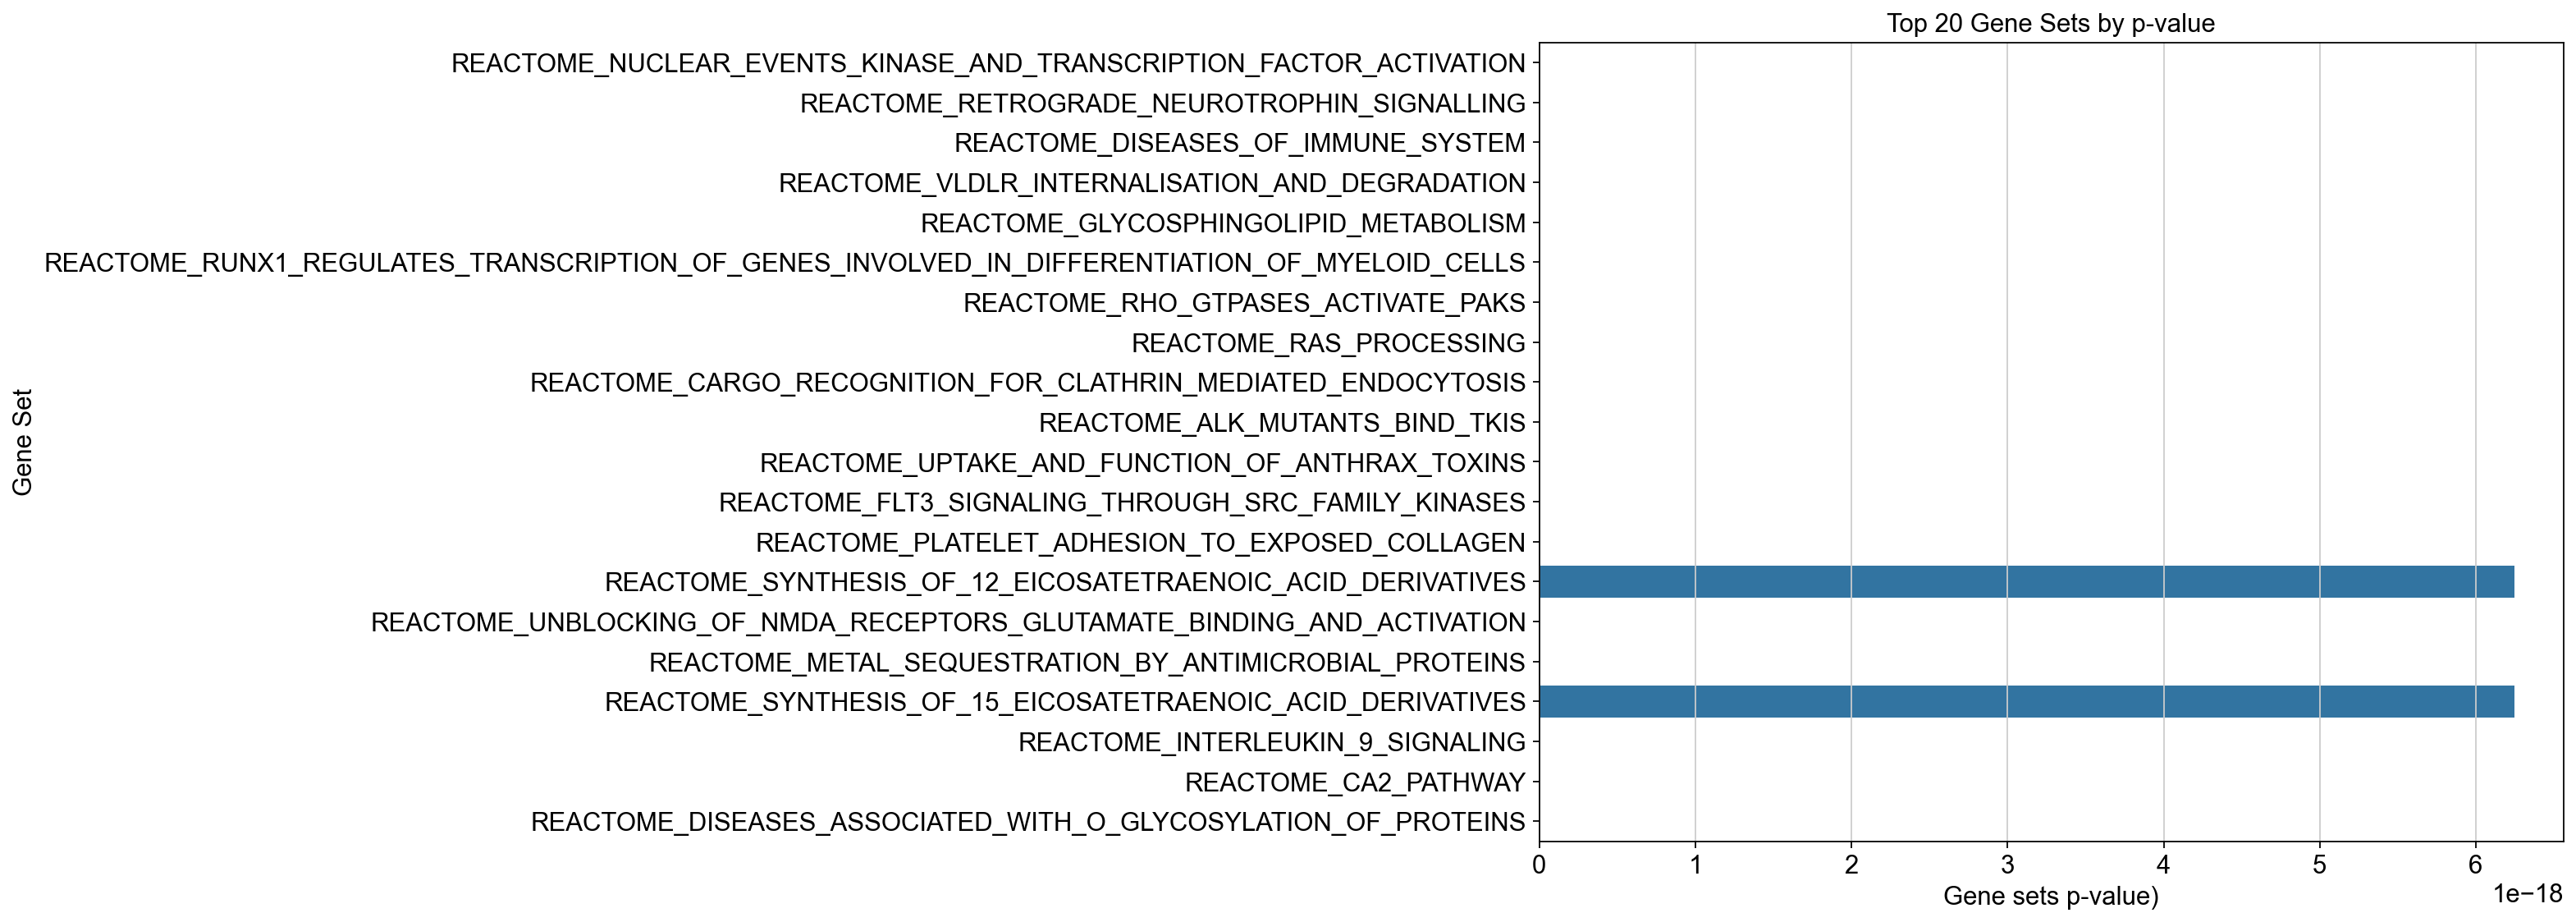

In [90]:
features = decoupler_feature_importance(scores, reactome, pvals)

## PROGENy
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. Here is a brief description of each pathway:
- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [13]:
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


To infer pathway enrichment scores we will run the multivariate linear model (mlm) method. For each cell in our dataset (adata), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

In [78]:
decoupler.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)
estimates = adata.obsm['mlm_estimate']
pvals = adata.obsm['mlm_pvals']

Running mlm on mat with 700 samples and 765 targets for 14 sources.


### Feature Importance

Shape of data: (700, 14)


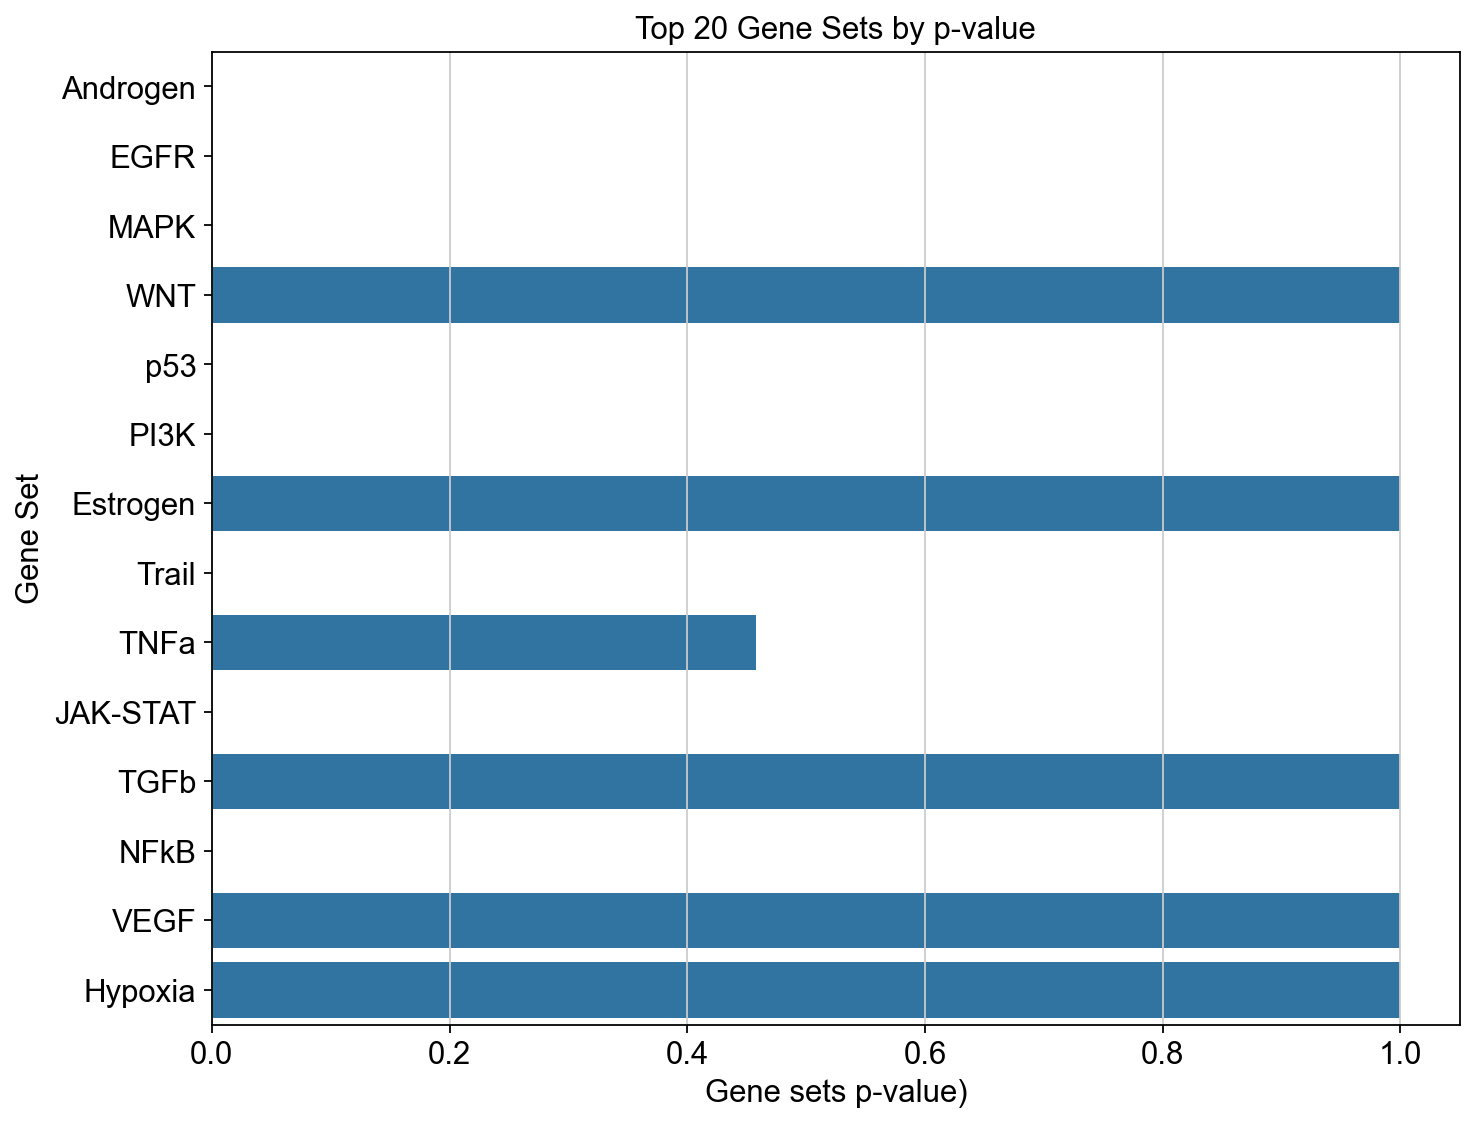

In [80]:
decoupler_feature_importance(estimates, reactome, pvals)

## AUCell

Unlike the previous approach where we assessed gene set *enrichment* per *cluster* (or rather cell type), one can *score* the activity level of pathways and gene sets in each individual cell, that is based on absolute gene expression in the cell, regardless of expression of genes in the other cells. This we can achieve by activity scoring tools such as `AUCell`.

Similar to `GSEA`, we will be using the `decoupler` implementation of `AUCell`. Make sure to run the previous cell for downloading the REACTOME gene sets.

In [62]:
decoupler.run_aucell(
    adata,
    reactome,
    source="geneset",
    target="genesymbol",
    use_raw=False,
    verbose=True
)
estimates = adata.obsm['aucell_estimate']

Running aucell on mat with 700 samples and 765 targets for 141 sources.


100%|██████████| 700/700 [00:01<00:00, 644.26it/s]


### Feature Importance

In [77]:
feature_importance(estimates, adata.obs.labels)

  0%|          | 0/141 [00:00<?, ?it/s]

Top 40 gene sets by clustering accuracy:
Pathway set: REACTOME_COSTIMULATION_BY_THE_CD28_FAMILY
Pathway set: REACTOME_INTERFERON_GAMMA_SIGNALING
Pathway set: REACTOME_NEUTROPHIL_DEGRANULATION
Pathway set: REACTOME_SEMAPHORIN_INTERACTIONS
Pathway set: REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION
Pathway set: REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM
Pathway set: REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT
Pathway set: REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S
Pathway set: REACTOME_AMINO_ACIDS_REGULATE_MTORC1
Pathway set: REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION
Pathway set: REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION
Pathway set: REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES
Pathway set: REACTOME_APC_C_MEDIATED_DEGRADATION_OF_CELL_CYCLE_PROTEINS
Pathway set: REACTOME_APOPTOSIS
Pathway set: REACTOME_ARACHIDONIC_ACID_METABOLISM
Pathway set: REACTOME_ASSOCIATION_OF_TRIC_CCT_WITH_TAR

## PathSingle

In [ ]:
activity_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
magic_op = magic.MAGIC()
activity_df = magic_op.fit_transform(activity_df)

activity_df.to_csv('./data/activity_df.csv', index=True)

Calculating MAGIC...
  Running MAGIC on 700 cells and 765 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.41 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 0.44 seconds.


### Run PathSingle

In [130]:
activity = sc.read('./data/activity_df.csv', delimiter=',', cache=False)
calc_activity(activity)

AnnData object with n_obs × n_vars = 700 × 765


100%|██████████| 140/140 [01:50<00:00,  1.27it/s]


### Feature Importance

In [76]:
output_activity = pd.read_csv('./data/output_activity.csv', index_col=0)
feature_importance(output_activity, adata.obs.labels)

  0%|          | 0/314 [00:00<?, ?it/s]

Top 40 gene sets by clustering accuracy:
Pathway set: MOxidative phosphorylation
Pathway set: Asthma
Pathway set: NLong-term potentiation
Pathway set: Malaria
Pathway set: MRiboflavin metabolism
Pathway set: Cell adhesion molecules
Pathway set: NAntigen processing and presentation
Pathway set: Adherens junction
Pathway set: African trypanosomiasis
Pathway set: AGE-RAGE signaling pathway in diabetic complications
Pathway set: Alcoholic liver disease
Pathway set: Alcoholism
Pathway set: Aldosterone-regulated sodium reabsorption
Pathway set: Allograft rejection
Pathway set: Aminoacyl-tRNA biosynthesis
Pathway set: Amoebiasis
Pathway set: Amphetamine addiction
Pathway set: AMPK signaling pathway
Pathway set: Antifolate resistance
Pathway set: Apelin signaling pathway
Pathway set: Apoptosis - multiple species
Pathway set: Arachidonic acid metabolism
Pathway set: Arrhythmogenic right ventricular cardiomyopathy
Pathway set: Autoimmune thyroid disease
Pathway set: Autophagy - other
Pathway set

### EDA

In [18]:
import pandas as pd
import numpy as np
import sweetviz as sv
from sklearn.preprocessing import Normalizer # Unit norm.


# Implement centering.
def center_rows(X):
    """Center each row by subtracting its mean, preserving distribution shape"""
    row_means = X.mean(axis=1, keepdims=True)
    return X - row_means

# Read original data.
df_original = pd.read_csv('./data/output_activity.csv', index_col=0)
# Remove columns with all zeros.
zero_cols = df_original.columns[df_original.eq(0).all()]
print(f"Removing {len(zero_cols)} columns with all zeros.")
df_original = df_original.drop(columns=zero_cols)

# Sample 20 random columns to reduce complexity.
sample_cols = np.random.choice(df_original.columns, size=20, replace=False)
df_sample = df_original[sample_cols]

# Scale sampled data.
def minmax_scale_rows(X):
    row_min = X.min(axis=1, keepdims=True)
    row_max = X.max(axis=1, keepdims=True)
    return (X - row_min) / (row_max - row_min)

scaler = Normalizer()
#df_scaled = pd.DataFrame(scaler.fit_transform(df_sample), index=df_sample.index, columns=df_sample.columns)
#df_scaled = pd.DataFrame(minmax_scale_rows(df_sample.values), index=df_sample.index, columns=df_sample.columns)
df_scaled = pd.DataFrame(center_rows(df_original.values), index=df_original.index, columns=df_original.columns)

try:
    report = sv.compare(
        [df_sample, "Original Sample"],
        [df_scaled, "Scaled Sample"],
        pairwise_analysis="off"
    )
    
    # Save report with explicit layout.
    report.show_html('activity_comparison.html')
except Exception as e:
    print(f"Error generating report: {str(e)}.")

Removing 4 columns with all zeros.


                                             |          | [  0%]   00:00 -> (? left)

Report activity_comparison.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
